## Install

In [ ]:

!pip install git+https://github.com/openai/CLIP.git
# Download weights
import os
for i in range(1, 6):
    if not os.path.isfile(f'checkpoint_10.{i}.pt'):
        !curl -L -O https://github.com/Zasder3/model_soups_colab/releases/download/weights/checkpoint_10.{i}.pt
if not os.path.isfile('cifar1098_idxs.npy'):
    !curl -L -O https://github.com/Zasder3/model_soups_colab/releases/download/weights/cifar1098_idxs.npy

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/pip-req-build-o1_qrwzl
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/pip-req-build-o1_qrwzl
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Load models and dataset

By starting with a pretrained model, we can perform supervised finetuning on a new task. Instead of only taking the best performing model of all of our runs, in model soup paper they do averaging to achieve a better set of weights. [paper](https://arxiv.org/abs/2203.05482).

Here we start with CLIP ViT-B/32 and finetuned on CIFAR10. The authors of the paper generously provided finetuned weights! I've saved us some time and uploaded the first 5 to GitHub.
All models can be found [here](https://drive.google.com/drive/folders/1KWNs03JRJM7i1CI3Mybpc9TsATY-fXNI).

In [47]:
import torch
import clip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from torchvision.datasets import CIFAR10
from torchvision.transforms import *
from tqdm.notebook import tqdm

In [ ]:
from torch.utils.data.dataset import Subset
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC

def _convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),  # TODO: what is this?
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

transforms = _transform(224)

# TODO: what is this for?
idxs = np.load('cifar1098_idxs.npy').astype('int')
indices = []
for i in range(len(idxs)):
  if idxs[i]:
    indices.append(i)

# TODO: why call val not train here??? 
val = CIFAR10(root='./data', train=True, download=True, transform=transforms)
val = Subset(val, indices)
test = CIFAR10(root='./data', train=False, download=True, transform=transforms)

valloader = torch.utils.data.DataLoader(val,
                                        batch_size=128,
                                        shuffle=False,
                                        num_workers=0,
                                        drop_last=False)
testloader = torch.utils.data.DataLoader(test,
                                         batch_size=128,
                                         shuffle=False,
                                         num_workers=0,
                                         drop_last=False)

In [39]:
def validate(model):
  preds = []
  labels = []
  for x, y in tqdm(valloader, desc="Run on val set"):
    x = x.to(device)
    y = y.to(device)
    preds.append(model(x).argmax(dim=1))
    labels.append(y)
  return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

def test(model):
  preds = []
  labels = []
  for x, y in tqdm(testloader,desc="Run on test set"):
    x = x.to(device)
    y = y.to(device)
    preds.append(model(x).argmax(dim=1))
    labels.append(y)
  return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

In [ ]:
class ModelWrapper(torch.nn.Module):
    """
    TODO: 
    """
    def __init__(self, model, feature_dim, num_classes, normalize=False, initial_weights=None):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.classification_head = torch.nn.Linear(feature_dim, num_classes)
        self.normalize = normalize
        if not self.normalize:
            print('normalize skipped.')

        if initial_weights is not None and type(initial_weights) == tuple:
            print('tuple.')
            w, b = initial_weights
            self.classification_head.weight = torch.nn.Parameter(w.clone())
            self.classification_head.bias = torch.nn.Parameter(b.clone())
        else:
            if initial_weights is None:
                initial_weights = torch.zeros_like(self.classification_head.weight)
                torch.nn.init.kaiming_uniform_(initial_weights, a=math.sqrt(5))
            self.classification_head.weight = torch.nn.Parameter(initial_weights.clone())
            # Note: modified. Initial bug in forgetting to zero bias.
            self.classification_head.bias = torch.nn.Parameter(torch.zeros_like(self.classification_head.bias))

        # Note: modified. Get rid of the language part.
        delattr(self.model, 'transformer')

    def forward(self, images):
        features = self.model.encode_image(images).float()
        if self.normalize:
            features = features / features.norm(dim=-1, keepdim=True)
        logits = self.classification_head(features)
        return logits

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
state_dicts = []

for f in os.listdir():
  if f[-2:] == 'pt':

    print(f'Loading {f}')
    state_dicts.append(torch.load(f, map_location=device))

state_dicts = state_dicts[:2]

Loading checkpoint_10.2.pt
Loading checkpoint_10.3.pt
Loading checkpoint_10.4.pt
Loading checkpoint_10.1.pt
Loading checkpoint_10.5.pt


In [16]:
len(state_dicts)

2

In [30]:
def get_model(state_dicts, alphal):
  """
  Get new model by merging the parameters from different fine-tunes (state dicts) of the base model, using linear combination
  """
  # get base model architectures
  model, _ = clip.load('ViT-B/32')
  feature_dim = state_dicts[0]['classification_head.weight'].shape[1]
  num_classes = state_dicts[0]['classification_head.weight'].shape[0]
  normalize = True
  model = ModelWrapper(model, feature_dim, num_classes, normalize)

  # merge parameters into new model
  sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}  # component from model 1
  for i in range(1, len(state_dicts)):
      for k in state_dicts[i].keys():
          sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i] # component from model i+1
  model.load_state_dict(sd)
  model = model.to(device)
  return model

## Individual Model - Baseline 🏁
Individual fine tunes of the model

In [ ]:
val_results = []
test_results = []

for i in range(len(state_dicts)):
  model, _ = clip.load('ViT-B/32')
  feature_dim = state_dicts[0]['classification_head.weight'].shape[1]
  num_classes = state_dicts[0]['classification_head.weight'].shape[0]
  normalize = True
  model = ModelWrapper(model, feature_dim, num_classes, normalize)
  model.load_state_dict(state_dicts[i])
  model = model.to(device)

  val_results.append(validate(model))
  test_results.append(test(model))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

([0, 1], [Text(0, 0, 'Model 1'), Text(1, 0, 'Model 2')])

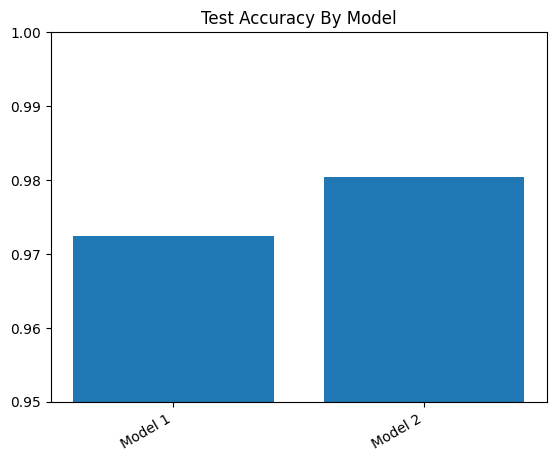

In [19]:
names = [f'Model {i+1}' for i in range(len(state_dicts))]
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([0.95,1])
plt.xticks(rotation=30, ha='right')

## Linear Combination of Two Models

From here our next step is to see what happens when we make soup the naïve way using simple averaging. This is called "Uniform Soup."

In [ ]:
test_res = pd.DataFrame(columns=["lambda", "test_accuracy"])
for lam in tqdm(np.arange(0, 1.0, 0.1), desc="List of combinations"):
    print(f"Testing combination: {lam}")
    alphal = [lam, 1-lam]
    model = get_model(state_dicts, alphal)
    test_acc = test(model)
    print(f"Test accuracy: {test_acc}")
    test_res = pd.concat([test_res, pd.DataFrame({"lambda": [lam], "test_accuracy": [test_acc]})], ignore_index=True)

List of combinations:   0%|          | 0/2 [00:00<?, ?it/s]

Testing combination: 0.0
Test accuracy: 0.4
Testing combination: 0.5


/var/folders/1h/bt3d3tyd2hb23vf674117s7c0000gp/T/ipykernel_63705/380802537.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_res = pd.concat([test_res, pd.DataFrame({"lambda": [lam], "test_accuracy": [test_acc]})], ignore_index=True)


Test accuracy: 0.4


In [50]:
test_res.to_csv("test_accuracy-all_linear_combinations.csv")

In [51]:
test_res

,lambda,test_accuracy
0,0.0,0.4
1,0.5,0.4


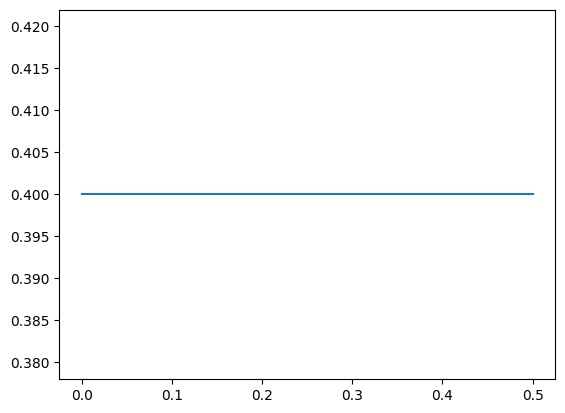

In [ ]:
plt.title("Test Accuracy of linear merge of two models")

plt.plot(test_res['lambda'], test_res['test_accuracy'])
plt.ylim([0.95,1])